# Simple Linear Regression and Bootstrapping Method

We can use the bootstrap method to get regression models. Bootstrapping a regression model gives insight into how variable the model parameters are. It is helpful to know how much random variation in regression coefficients is due to small data values change. 

It is possible to bootstrap almost any regression model, but it can be computationally intensive.

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style("whitegrid")

## The Data

In [2]:
df = pd.read_csv('salary_data.csv')
print(df.shape)
df.head()

(30, 2)


,YearsExperience,Salary
0,1.1,39343
1,1.3,46205
2,1.5,37731
3,2.0,43525
4,2.2,39891


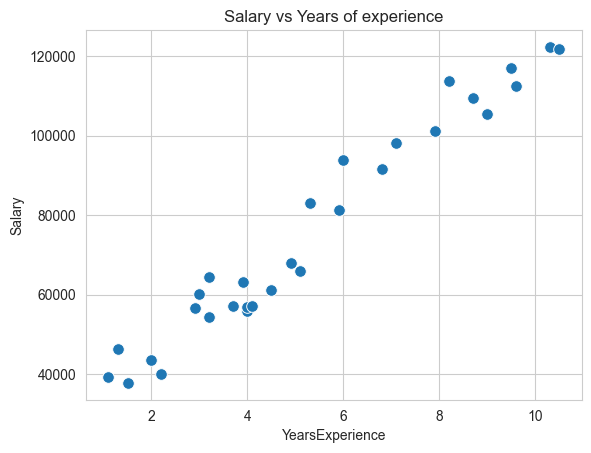

In [3]:
# Plotting the data
sns.scatterplot(x='YearsExperience', y='Salary', s=70, data=df).set_title('Salary vs Years of experience');

## The Model

In [4]:
x = np.array(df.YearsExperience)
y = np.array(df.Salary)

In [5]:
# Adding the constant term
xc = sm.add_constant(x)

In [6]:
# Defining the Ordinary Least Squares model and fitting it
model = sm.OLS(y, xc).fit()

In [7]:
# Getting the estimated parameters
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     622.5
Date:                Wed, 21 Feb 2024   Prob (F-statistic):           1.14e-20
Time:                        11:59:06   Log-Likelihood:                -301.44
No. Observations:                  30   AIC:                             606.9
Df Residuals:                      28   BIC:                             609.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.579e+04   2273.053     11.347      0.000    2.11e+04    3.04e+04
x1          9449.9623    378.755     24.950      0.000    8674.119    1.02e+04
==============================================================================
Omnibus:                        2.140   Durbin-Watson:                   1.648
Prob(Omnibus):                  0.343   Jarque-Bera (JB):                1.569
Skew:                           0.363   Prob(JB):                        0.456
Kurtosis:                       2.147   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
print('Coefficient of determination: %.3f' %(model.rsquared))

Coefficient of determination: 0.957


In [9]:
intercept = model.params[0] 
slope     = model.params[1] 

In [10]:
# Printing the model
eq = 'Salary = %.1f * YearsExperience + %.1f' %(slope, intercept)
eq

'Salary = 9450.0 * YearsExperience + 25792.2'

In [11]:
# Getting the predicted values
df['predict'] = model.predict()
df.head()

,YearsExperience,Salary,predict
0,1.1,39343,36187.158752
1,1.3,46205,38077.151217
2,1.5,37731,39967.143681
3,2.0,43525,44692.124842
4,2.2,39891,46582.117306


The goal of `sns.lmplot` is to create a scatter plot with a linear regression line to visualize the relationship between two variables and examine the linear trend between them. 

The shaded area represents the confidence interval, a range of values around a statistical estimate that quantifies the uncertainty associated with that estimate. It provides a range within which the true value is likely to fall with a certain confidence level (e.g., 95% confidence interval), helping to assess the estimate's reliability. 

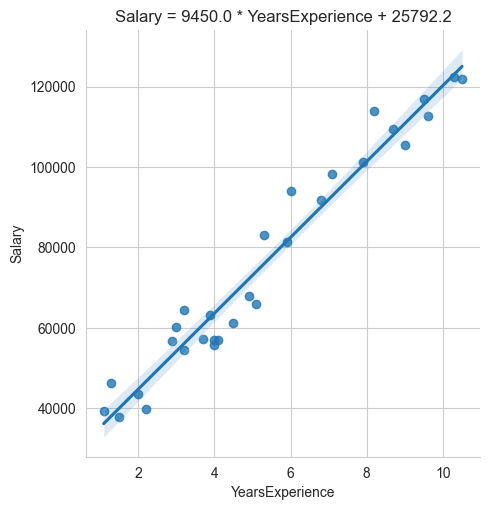

In [12]:
# Plotting the sacatter plot, the regression line, and the 95% confidence interval (default value)
sns.lmplot(data=df, x = 'YearsExperience', y = 'Salary').set(title = eq);

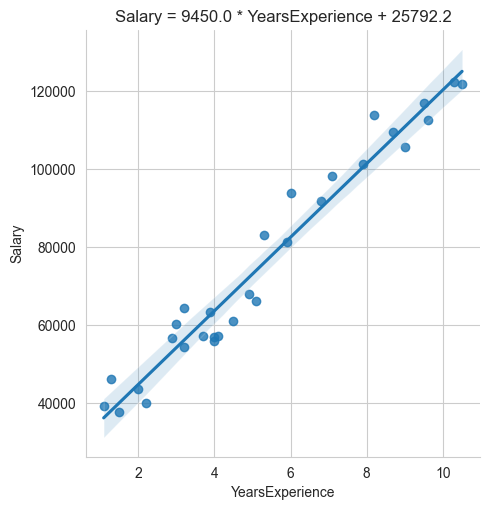

In [13]:
# Plotting the sacatter plot, the regression line, and the 99% confidence interval
sns.lmplot(data=df, x = 'YearsExperience', y = 'Salary', ci=99).set(title = eq);

## Bootstrapping Method

We will get the sampling distribution for both parameters of the simple regression model: the slope and the intercept.

In [14]:
def get_boot_simple_regressions(x, y, num_samples=10000):
    '''
    It returns two NumPy arrays with the sample distributions for slope and intercept.
    '''
    sample_size = len(x)        
    x = np.array(x)
    y = np.array(y)

    def get_model():
        '''
        It gets a resample of the data and returns the slope and intercept of the regression line.
        '''
        idx = np.random.choice(range(sample_size), replace=True, size=sample_size)
        xi = x[idx]
        yi = y[idx]        
        xic = sm.add_constant(xi)
        modeli = sm.OLS(yi, xic).fit()        
        return modeli.params[1], modeli.params[0]
    
    results = [get_model() for _ in range(num_samples)]

    slopeSD, interceptSD = zip(*results)
    return np.array(slopeSD), np.array(interceptSD)

In [15]:
slope_sample_distribution, intercept_sample_distribution = get_boot_simple_regressions(x, y)

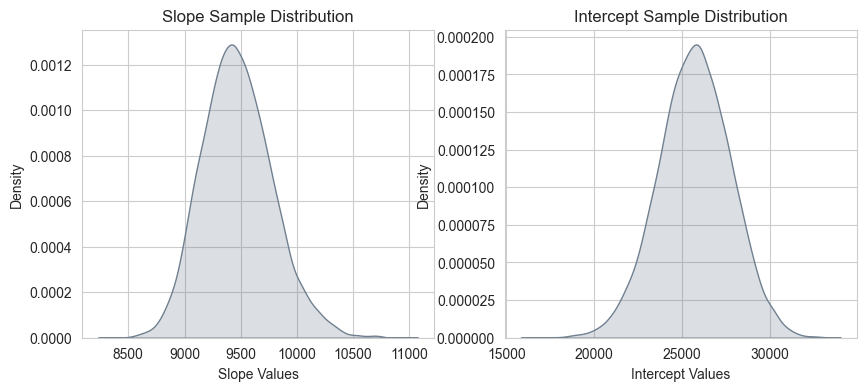

In [16]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
sns.kdeplot(slope_sample_distribution, fill=True, color='slategrey').set(
    title='Slope Sample Distribution', xlabel='Slope Values', ylabel='Density')

plt.subplot(122)
sns.kdeplot(intercept_sample_distribution, fill=True, color='slategrey').set(
    title='Intercept Sample Distribution', xlabel='Intercept Values', ylabel='Density');

### Bootstrap Confidence Intervals

To determine whether the model is significant, we can compute the confidence interval of the slope and analyze if it contains the zero value.

In [17]:
def confidence_interval(sample_distribution, confidence):
    '''
    This function return a confidence% confidente interval using 
    sample_distribution as a sample distribution.
    '''
    alpha = 100 - confidence
    lower_percentile = alpha / 2.0    
    lower_limit = np.percentile(sample_distribution, lower_percentile)
    upper_percentile = lower_percentile + confidence
    upper_limit = np.percentile(sample_distribution, upper_percentile)
    return(lower_limit, upper_limit)

In [18]:
# Getting confidence intervals for the slope 
lower90, upper90 = confidence_interval(slope_sample_distribution, 90)
lower95, upper95 = confidence_interval(slope_sample_distribution, 95)
lower99, upper99 = confidence_interval(slope_sample_distribution, 99)

In [19]:
print('90%% Confidence Interval for slope = (%.2f, %.2f)' % (lower90, upper90))
print('95%% Confidence Interval for slope = (%.2f, %.2f)' % (lower95, upper95))
print('99%% Confidence Interval for slope = (%.2f, %.2f)' % (lower99, upper99))

90% Confidence Interval for slope = (8988.89, 10014.32)
95% Confidence Interval for slope = (8905.06, 10142.17)
99% Confidence Interval for slope = (8745.84, 10365.22)


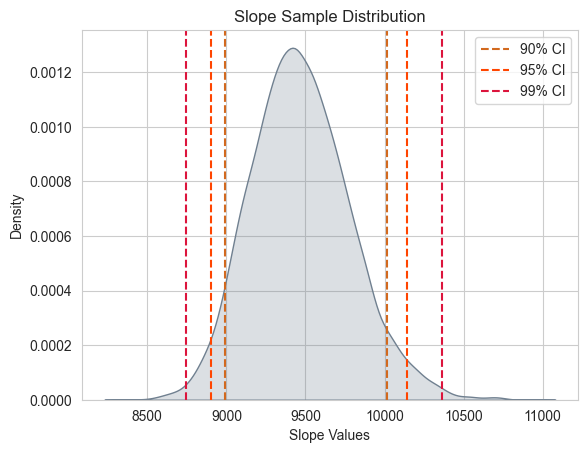

In [20]:
# Ploting the confidence intervals
sns.kdeplot(slope_sample_distribution, fill=True, color='slategrey').set(
    title='Slope Sample Distribution', xlabel='Slope Values', ylabel='Density')

plt.axvline(lower90, color='chocolate', linestyle='dashed', label = '90% CI')
plt.axvline(upper90, color='chocolate', linestyle='dashed')

plt.axvline(lower95, color='orangered', linestyle='dashed', label = '95% CI')
plt.axvline(upper95, color='orangered', linestyle='dashed')

plt.axvline(lower99, color='crimson', linestyle='dashed', label = '99% CI')
plt.axvline(upper99, color='crimson', linestyle='dashed')

plt.legend();

If the confidence interval for the slope of a simple linear regression model does not include zero, it indicates that there is a statistically significant relationship between the predictor variable and the response variable. In other words, we can be reasonably confident that the slope is different from zero, suggesting that changes in the predictor variable are associated with changes in the response variable.

### Bootstrap Hypothesis Test for the model

In [21]:
def get_p_value(sample_distribution, obs_value, alternative='two-sided'):    
    '''
    It returns the p-value.
    sample_distribution:    the sample distribution
    obs_value:              the observed value     
    alternative:            'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        p_val = 2*min(ecdf(obs_value), 1 - ecdf(obs_value))        
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

In [22]:
def graph_hyp_test(sample_value, sample_distribution, alpha=0.05, alternative='two-sided'):
    '''
    It computes and graph the two-samples hypothesis test.
    sample_value:           observed value calculated from the sample
    sample_distribution:    sample distribution calculated from the sample
    alpha:                  significance level
    alternative:            'two-sided', 'smaller', and 'larger'
    '''
    print('--- Hypothesis Test ---')
    # plotting the sample distribution
    sns.kdeplot(x=sample_distribution, color='skyblue', fill=True).set_title('Sample Distribution')  
    # plotting the statistic
    plt.axvline(x=sample_value, ymin=0, ymax= 0.03, color='black', linewidth=6)       
    # get the p-value
    p_val = get_p_value(sample_distribution, sample_value, alternative)
    # plotting the two critical regions
    if alternative=='two-sided':        
        cv1 = np.round(np.percentile(sample_distribution, (alpha/2)*100),2)         # left critical value    
        cv2 = np.round(np.percentile(sample_distribution, 100-(alpha/2)*100),2)     # right critical value    
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2);
    # plotting the left critical region
    elif alternative=='smaller':        
        cv1 = np.round(np.percentile(sample_distribution, alpha*100),2)             # left critical value
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    # plotting the right critical region
    else:                               
        cv2 = np.round(np.percentile(sample_distribution, 100-alpha*100),2)         # right critical value
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    # printing the statistic and the p-value    
    print('Observed Value = %.2f\tp-value = %.4f' %(sample_value, p_val))  

We are interested in determining whether the model' slope is significantly different from 0.

--- Hypothesis Test ---
Observed Value = 0.00	p-value = 0.0000


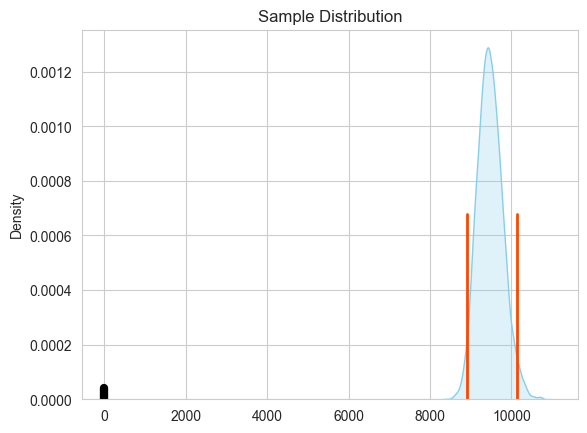

In [23]:
graph_hyp_test(0, slope_sample_distribution)

The model is significant!

### Plotting the Bootstrap Regression Models

Let's create a function for creating and ploting the bootstrap models.

In [24]:
def plot_boot_reg_models(x, y, slopeSD, interceptSD):
    """
    It plots multiple models defined by slopeSD and interceptSD in grey,
    and computes and plots the original linear regression model from x and y in red.
    """
    # Generate 100 x values for the plot
    x_values = np.linspace(min(x)-1, max(x)+1, 100)

    for m, b in zip(slopeSD, interceptSD):
        plt.plot(x_values, m * x_values + b, color='slategrey', linewidth=1, alpha=0.3)
    
    # Getting the model x vs y
    xc = sm.add_constant(x)
    model = sm.OLS(y, xc).fit()
    slope, intercept = model.params[1], model.params[0]

    # Plot the model and the scatterplot in red
    plt.plot(x_values, slope * x_values + intercept, color='darkred', linewidth=2)    
    plt.scatter(x, y, color='darkred', s=15)

    # Add labels and title for clarity
    plt.xlabel("x values")
    plt.ylabel("y values")
    plt.title("%d Bootstrap Regression Models" %len(slopeSD))

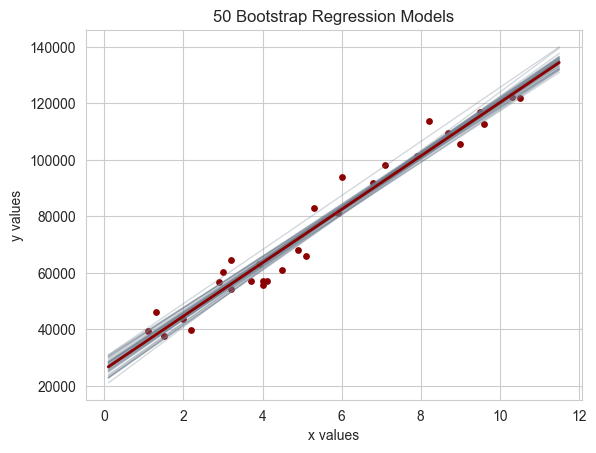

In [25]:
# Plotting 50 bootstrap regression models
plot_boot_reg_models(x, y, slope_sample_distribution[:50], intercept_sample_distribution[:50])

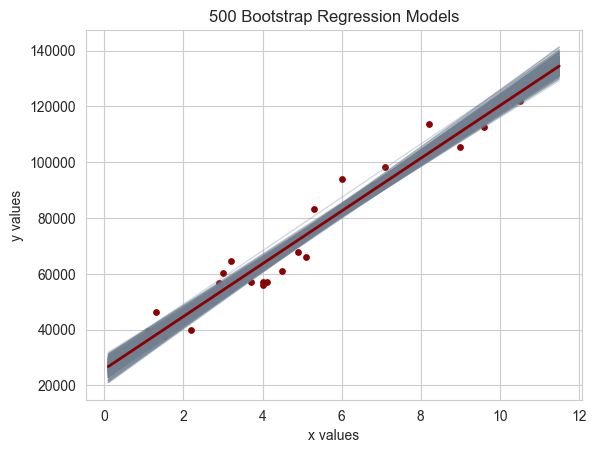

In [26]:
# Plotting 500 bootstrap regression models
plot_boot_reg_models(x, y, slope_sample_distribution[:500], intercept_sample_distribution[:500])

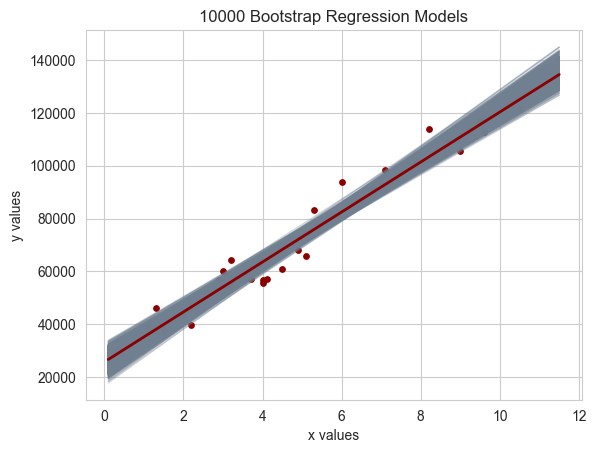

In [27]:
# Plotting all bootstrap regression models
plot_boot_reg_models(x, y, slope_sample_distribution, intercept_sample_distribution)

As you can see, predictions are more reliable near the center of the graph and less at the extremes. Confidence intervals are wider at the extremes. Let's plot them!

In [28]:
def plot_boot_ci(x, y, slopeSD, interceptSD, confidence=95):
    """
    It computes and plots the model and the confidence interval
    """
    # Generate 100 x values for the plot
    x_values = np.linspace(min(x)-1, max(x)+1, 100)

    # Getting the model x vs y
    xc = sm.add_constant(x)
    model = sm.OLS(y, xc).fit()
    slope, intercept = model.params[1], model.params[0]

    # Plot the model in red
    plt.plot(x_values, slope * x_values + intercept, color='darkred', linewidth=2)   
    
    # Storing values for each model from slopeSD and interceptSD    
    models = pd.DataFrame({i: [m * x + b for x in x_values] 
                           for i, (m, b) in enumerate(zip(slopeSD, interceptSD))}, index=x_values)    
    
    # Getting the confidence intervals for each x
    percentile_low = (100 - confidence)/2
    percentile_upp = 100 - percentile_low    
    low_list = []
    upp_list = []
    for x in models.index:        
        low, upp = np.percentile(models.loc[x], [percentile_low, percentile_upp])
        low_list.append(low)
        upp_list.append(upp)        
    
    plt.fill_between(models.index, low_list, upp_list, color='slategrey', alpha=0.5)     
       
    # Add labels and title for clarity
    plt.xlabel("x values")
    plt.ylabel("y values")
    plt.title("Regression Model (%d%% Confidence Interval)" % confidence)
    plt.show()

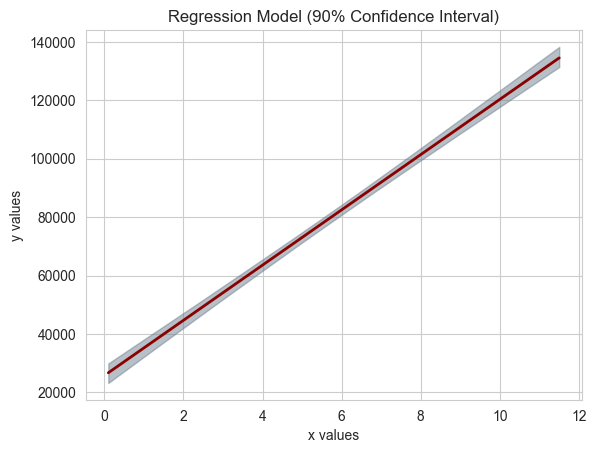

In [29]:
plot_boot_ci(x, y, slope_sample_distribution, intercept_sample_distribution, confidence=90)

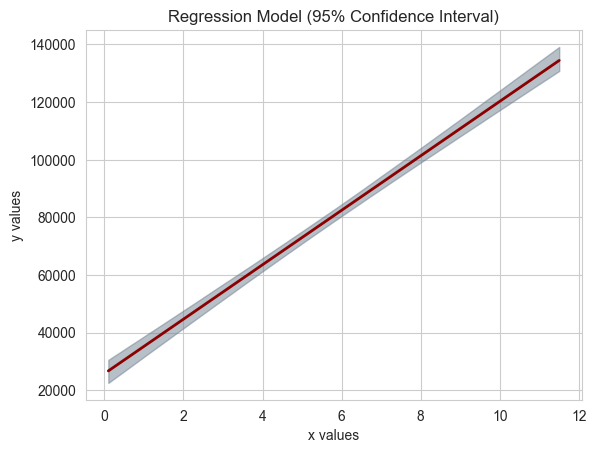

In [30]:
plot_boot_ci(x, y, slope_sample_distribution, intercept_sample_distribution)

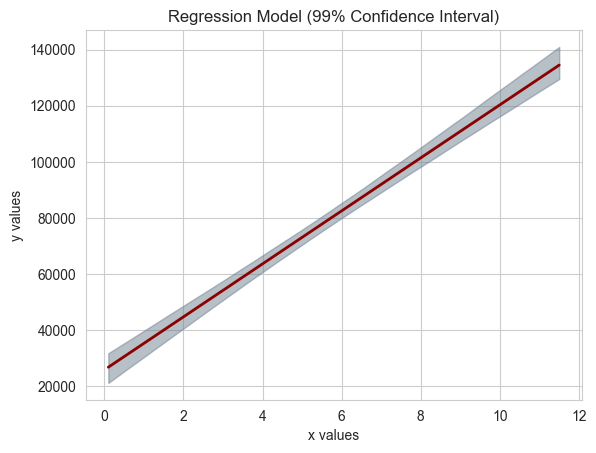

In [31]:
plot_boot_ci(x, y, slope_sample_distribution, intercept_sample_distribution, confidence=99)

Computing confidence intervals around a trendline is a valuable statistical technique in data analysis and visualization for several reasons:
- Confidence intervals provide a range of values around the trendline likely to contain the true parameters with a specified confidence level. 
- Confidence intervals help evaluate the goodness of fit of the model. If the confidence interval is narrow and close to the trendline, the data points are closely clustered around the line, suggesting a good fit. A wider confidence interval may indicate a less precise or less reliable model.
- Confidence intervals allow for the comparison of different models. A narrower and more precise confidence interval typically suggests a better model.
- Wide confidence intervals for specific data points may indicate the presence of outliers or influential data that disproportionately affect the model's fit. 
- When presenting data and trends to others, including confidence intervals in visualizations or reports provides a more complete picture of the data's reliability.

## References

- VanderPlas, J. (2017) Python Data Science Handbook: Essential Tools for Working with Data. USA: O’Reilly Media, Inc. chapter 4.